# Medicina Personalizada - Redefinindo o Tratamento de Câncer
## https://www.datascienceacademy.com.br

Muito tem sido dito durante os últimos anos sobre como a medicina de precisão e, mais concretamente, como o teste genético, vai provocar disrupção no tratamento de doenças como o câncer.

Mas isso ainda está acontecendo apenas parcialmente devido à enorme quantidade de trabalho manual ainda necessário. Neste projeto, levamos a medicina personalizada ao seu potencial máximo.

Uma vez sequenciado, um tumor cancerígeno pode ter milhares de mutações genéticas. O desafio foi distinguir as mutações que contribuem para o crescimento do tumor das mutações.

Atualmente, esta interpretação de mutações genéticas está sendo feita manualmente. Esta é uma tarefa muito demorada, onde um patologista clínico tem que revisar manualmente e classificar cada mutação genética com base em evidências da literatura clínica baseada em texto.

Para este projeto, o MSKCC (Memorial Sloan Kettering Cancer Center) disponibilizou uma base de conhecimento anotada por especialistas, onde pesquisadores e oncologistas de nível mundial anotaram manualmente milhares de mutações.

O dataset completo pode ser encontrado em:
https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

## O objetivo
 
- Desenvolver um algoritmo de Machine Learning para classificar automaticamente as variacoes genéticas

## Descrição dos arquivos
- training_variants e test_variants: um arquivo separado por vírgula contendo a descrição das mutações genéticas usadas para treinamento. Os campos são ID (o id da linha usada para vincular a mutação à evidência clínica), GENE (o gene onde essa mutação genética estão localizadas), VARIACAO (a mudança de aminoácido para essas mutações), CLASSE (1-9 a classe que a mutação genética foi classificada)

- training_text e test_text: um arquivo delimitado por (||) que contém a evidência clínica (texto) usada para classificar as mutações genéticas. Os campos são ID (o id da linha usada para vincular a evidência clínica à mutação genética), TEXT (a evidência clínica usada para classificar a mutação genética)

## Extraindo e Carregando os Dados

Importando bibliotecas que serao utilizadas neste projeto

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

Vamos carregar os arquivos usando o pandas

In [2]:
train_variants = pd.read_csv("data/training_variants")
test_variants = pd.read_csv("data/test_variants")

train_text = pd.read_csv("data/training_text", sep="\|\|", engine="python", skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("data/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID","Text"])

## Análise Exploratória de Dados

Aalisando o shape dos arquivos

In [3]:
print("Train and Test variants shape : ",train_variants.shape, test_variants.shape)
print("Train and Test text shape : ",train_text.shape, test_text.shape)

Train and Test variants shape :  (3321, 4) (5668, 3)
Train and Test text shape :  (139, 2) (139, 2)


Visualizando as primeiras linhas do dataset de treino (variantes)

In [4]:
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Visualizando as primeiras linhas do dataset de treino (texto)

In [5]:
train_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


Verificando a quantidade de registros unicos para cada coluna

In [6]:
print("Unique IDs: ", len(train_variants.ID.unique()))
print("Unique Genes: ", len(train_variants.Gene.unique()))
print("Unique Variations: ", len(train_variants.Variation.unique()))
print("Unique Classes: ", len(train_variants.Class.unique()))

Unique IDs:  3321
Unique Genes:  264
Unique Variations:  2996
Unique Classes:  9


Verificando valores missing

In [7]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

In [8]:
missing = percent_missing(train_variants)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing for train_variants: ')
df_miss[0:6]

Percent of missing for train_variants: 


[('ID', 0.0), ('Gene', 0.0), ('Variation', 0.0), ('Class', 0.0)]

In [9]:
missing = percent_missing(train_text)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing for train_text: ')
df_miss[0:6]

Percent of missing for train_text: 


[('ID', 0.0), ('Text', 0.0)]

Verificando a distribuicao de frequencia das classes usando o countplot (nosso TARGET)

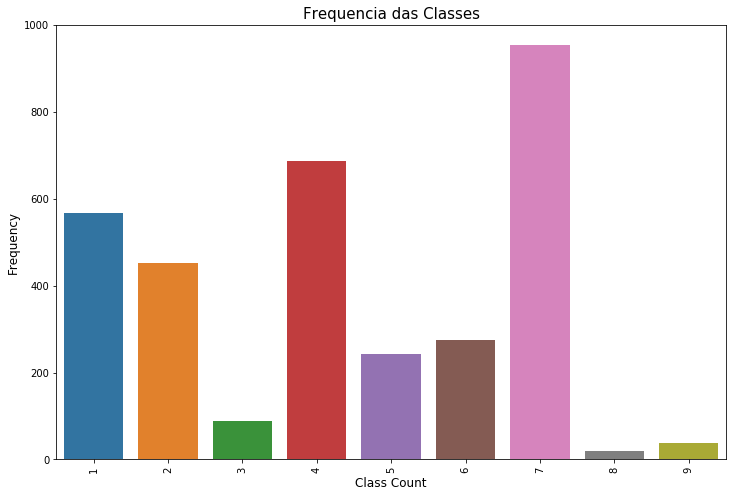

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_variants)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequencia das Classes", fontsize=15)
plt.show()

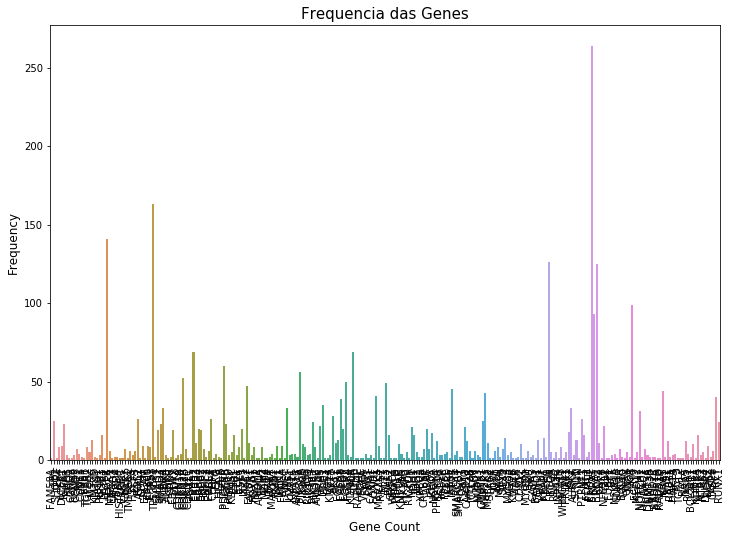

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x="Gene", data=train_variants)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Gene Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequencia das Genes", fontsize=15)
plt.show()

Com esse grafico percebemos que apenas alguns Genes estao acima de 100 registros

Verificando a distribuicao de frequencia da coluna "Gene" usando um distplot

In [12]:
group_gene_train = train_variants.groupby('Gene')['Gene'].count()

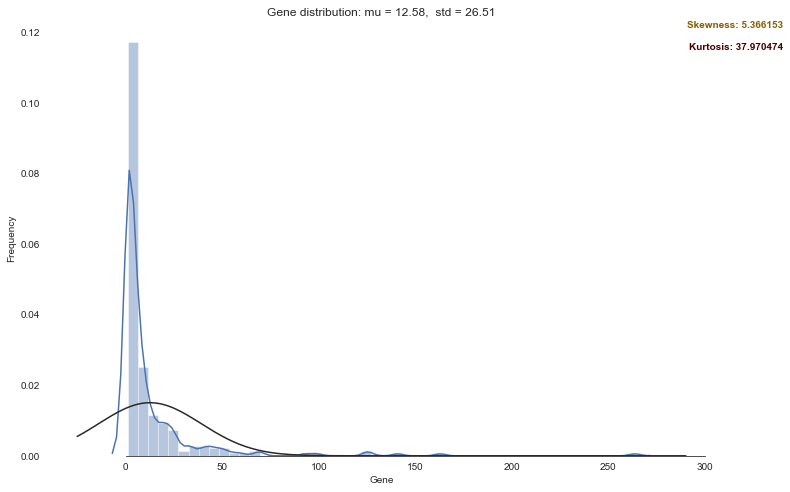

In [13]:
from scipy.stats import skew, norm
from scipy import stats

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 8))

# Fit a normal distribution
mu, std = norm.fit(group_gene_train)

# Verificando a distribuicao de frequencia da coluna GENE
sns.distplot(group_gene_train, color="b", fit = stats.norm, bins=50);
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Gene")
ax.set(title="Gene distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % group_gene_train.skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % group_gene_train.kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')


plt.show()

Verificando a distribuicao de frequencia da coluna "Variation"

In [14]:
group_variation = train_variants.groupby('Variation')['Variation'].count()

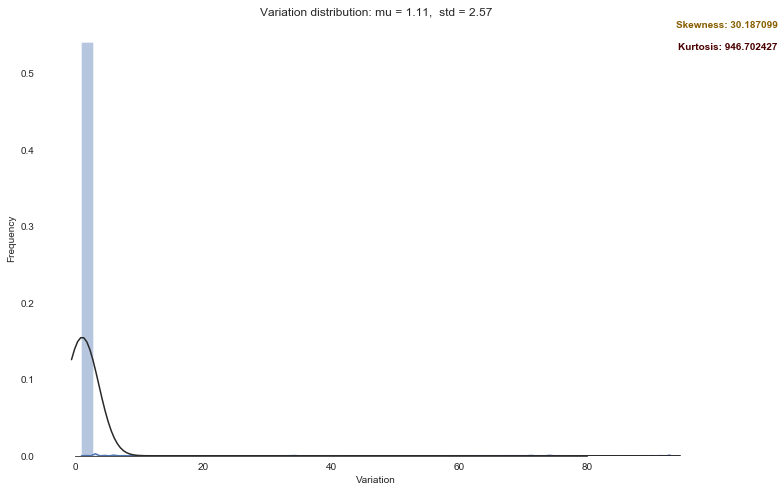

In [15]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 8))

# Fit a normal distribution
mu, std = norm.fit(group_variation)

# Verificando a distribuicao de frequencia da coluna Variation
sns.distplot(group_variation, color="b", fit = stats.norm, bins=50);
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Variation")
ax.set(title="Variation distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % group_variation.skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % group_variation.kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')


plt.show()

Verificando a quantidade de cada um dos textos

In [16]:
train_text.loc[:, 'text_count'] = train_text["Text"].apply(lambda x: len(x.split()))
train_text.head()

,ID,Text,text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5756
2,2,Abstract Background Non-small cell lung canc...,5756
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


In [17]:
test_text.loc[:, 'text_count'] = test_text["Text"].apply(lambda x: len(x.split()))
test_text.head()

,ID,Text,text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5756
2,2,Abstract Background Non-small cell lung canc...,5756
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


Vamos fazer o merge dos dois dataset unindo pelo ID

In [18]:
train_full = pd.merge(train_variants, train_text, how='left', on='ID')
test_full = pd.merge(test_variants, test_text, how='left', on='ID')

In [19]:
train_full.head()

,ID,Gene,Variation,Class,Text,text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089.0
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756.0
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756.0
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572.0
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202.0


In [20]:
test_full.head()

,ID,Gene,Variation,Text,text_count
0,0,ACSL4,R570S,Cyclin-dependent kinases (CDKs) regulate a var...,6089.0
1,1,NAGLU,P521L,Abstract Background Non-small cell lung canc...,5756.0
2,2,PAH,L333F,Abstract Background Non-small cell lung canc...,5756.0
3,3,ING1,A148D,Recent evidence has demonstrated that acquired...,5572.0
4,4,TMEM216,G77A,Oncogenic mutations in the monomeric Casitas B...,6202.0


Verificando valores null após o merge

In [21]:
missing = percent_missing(train_full)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing for train_variants: ')
df_miss[0:6]

Percent of missing for train_variants: 


[('Text', 95.81),
 ('text_count', 95.81),
 ('ID', 0.0),
 ('Gene', 0.0),
 ('Variation', 0.0),
 ('Class', 0.0)]

In [22]:
missing = percent_missing(test_full)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing for train_variants: ')
df_miss[0:6]

Percent of missing for train_variants: 


[('Text', 97.55),
 ('text_count', 97.55),
 ('ID', 0.0),
 ('Gene', 0.0),
 ('Variation', 0.0)]

Removendo valores nulos dos datasets e treino e teste

In [23]:
train_full = train_full.dropna()
test_full = test_full.dropna()

Tem alguns registros com texto duplicado para a mesma classe. Vamos agrupar e dar uma olhada nos dados estatisticos atraves da funcao describe

In [24]:
group_class = train_full.groupby('Class')["text_count"]

In [25]:
group_class.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,37.0,10527.918919,7998.692117,2419.0,3715.00,8011.0,17335.0,30856.0
2,10.0,7832.200000,2669.779467,5325.0,5904.75,6785.0,9063.0,12342.0
3,1.0,5572.000000,NaN,5572.0,5572.00,5572.0,5572.0,5572.0
4,53.0,6995.792453,5421.115580,1307.0,3539.00,5721.0,6648.0,25594.0
5,6.0,7930.666667,4778.826244,5654.0,5791.00,6202.0,6202.0,17670.0
6,1.0,11958.000000,NaN,11958.0,11958.00,11958.0,11958.0,11958.0
7,15.0,11165.266667,7149.797974,1.0,4347.00,12342.0,18343.0,21016.0
8,1.0,20626.000000,NaN,20626.0,20626.00,20626.0,20626.0,20626.0
9,15.0,11736.800000,10233.596360,1147.0,7440.50,10930.0,11497.0,45177.0


Existem algumas classes com somente um registro com texto sobre a mutacao genetica. 

Analisando como ficou a distribuicao das classes geneticas que tem evidencia clinica

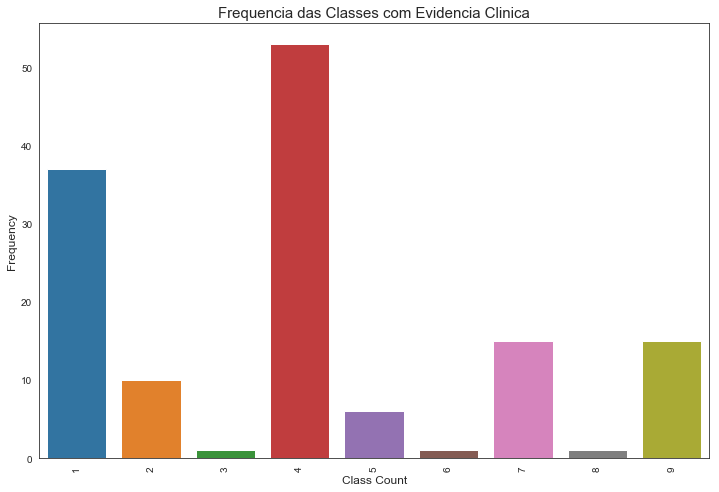

In [26]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_full)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequencia das Classes com Evidencia Clinica", fontsize=15)
plt.show()

Vamos verificar o numero de palavras usando um boxplot para cada uma das classes

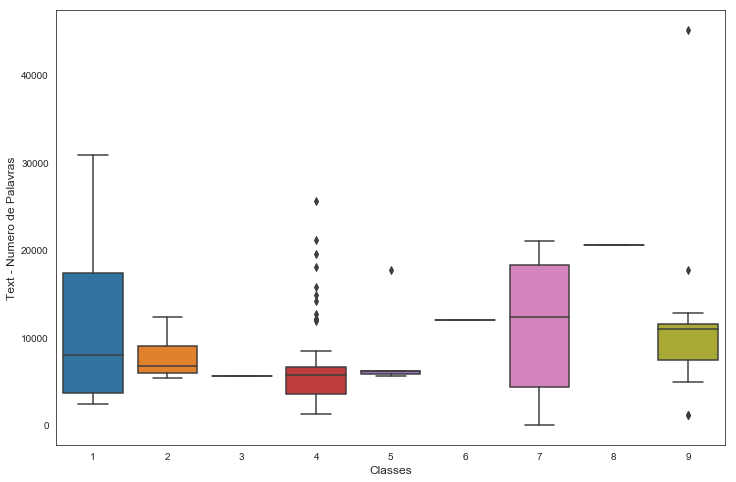

In [27]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='text_count', data=train_full)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Text - Numero de Palavras', fontsize=12)
plt.show()

### Resumo Geral dessa primeira análise exploratória

- Existem 3321 IDs diferentes no conjunto de treinamento contendo 264 expressões de Genes diferentes com 2996 variações. Existem 9 classes diferentes indicadas por numeros inteiros.

- Há 5668 IDs diferentes no dataset de teste (70,6% a mais dados que no dataset de treinamento). A descrição no Kaggle diz que "...Some of the test data is machine-generated to prevent hand labeling. You will submit all the results of your classification algorithm, and we will ignore the machine-generated samples...", o que deve explicar esse desequilíbrio.

- Não há valores missing no dataset das variants

Observacoes sobre a nossa variavel TARGET:

- As classes 3, 8, e 9 nao possuem muita representatividade nos dados
- As classes 5 e 6 estao bem proximas e com uma frequencia media
- As classes 1, 2, e 4 estao em uma frequencia media-alta
- A classe 7 é a mais frequente


## Preparando os Dados de Texto

Criando algumas funcoes para limpeza do texto

In [28]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
import re
import string

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

Realizando a limpeza do texto nos dados de treino

In [29]:
all_train_text = train_full['Text'].apply(cleanup)
sentences = constructLabeledSentences(all_train_text)
all_train_text.head()

0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

Realizando a limpeza do texto nos dados de test

In [30]:
all_test_text = test_full['Text'].apply(cleanup)
sentences = constructLabeledSentences(all_test_text)
all_test_text.head()

0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

Vamos aplicar a funcao LancasterStemmer para diminuir a formas de palavras distintas. Isso poderia ajudar a reduzir o tamanho do vocabulário, aprimorando os resultados

In [31]:
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

for i in range(len(all_train_text)):
    all_train_text[i] = st.stem(all_train_text[i])

for i in range(len(all_test_text)):
    all_test_text[i] = st.stem(all_test_text[i])

Vamos usar a funcao CountVectorizer para pegar as palavras de cada frase e cria um vocabulário de todas as palavras únicas nas frases. Este vocabulário pode então ser usado para criar um vetor de recurso da contagem das palavras:

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

count_vectorizer = TfidfVectorizer(ngram_range=(1,1)
                                  ,max_df=0.65
                                  ,tokenizer=nltk.word_tokenize
                                  ,strip_accents='unicode'
                                  ,lowercase =True
                                  ,analyzer='word'
                                  ,token_pattern=r'\w+'
                                  ,use_idf=True
                                  ,smooth_idf=True
                                  ,sublinear_tf=False
                                  ,stop_words = 'english')
bag_of_words = count_vectorizer.fit_transform(all_train_text)
print(bag_of_words.shape)

X_test = count_vectorizer.transform(all_test_text)
print(all_test_text.shape)

(139, 33732)
(139,)


Este vocabulário serve também como um índice de cada palavra. Agora, vamos pegar cada frase e obter a palavra ocorrências das palavras com base no vocabulário anterior. O vocabulário consiste em todas as palavras em nossas sentenças, cada uma representando uma palavra no vocabulário.

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False)
transformer_bag_of_words = transformer.fit_transform(bag_of_words)
print (transformer_bag_of_words.shape)

X_test_transformer = transformer.transform(X_test)
print (X_test_transformer.shape)

(139, 33732)
(139, 33732)


Agora vamos aplicar um label encoder para a classe categorica (variavel target)

In [34]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

train_y = train_full['Class'].values
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))

Using TensorFlow backend.


Em seguida aplicamos o LabelEncoder tambem para as features 'Gene' e 'Variation'

In [35]:
gene_le = LabelEncoder()
gene_encoded = gene_le.fit_transform( np.hstack((train_full['Gene'].values.ravel()
                                                ,test_full['Gene'].values.ravel()))).reshape(-1, 1)
gene_encoded = gene_encoded / float(np.max(gene_encoded))


variation_le = LabelEncoder()
variation_encoded = variation_le.fit_transform( np.hstack((train_full['Variation'].values.ravel()
                                                          ,test_full['Variation'].values.ravel()))).reshape(-1, 1)
variation_encoded = variation_encoded / float(np.max(variation_encoded))

Criamos as variaveis X (features) e y (target)

In [36]:
from scipy.sparse import hstack

# Dados de Treino
X = hstack((gene_encoded[:train_full.shape[0]]
           ,variation_encoded[:train_full.shape[0]]
           ,transformer_bag_of_words)).todense()
y = encoded_y

# Datos de Teste
X_test = hstack((gene_encoded[:test_full.shape[0]]
                 ,variation_encoded[:test_full.shape[0]]
                 ,X_test_transformer)).todense()

In [37]:
X.shape, y.shape, X_test.shape

((139, 33734), (139, 9), (139, 33734))

## Criação os modelos de Machine Learning

Realizando o split do dataset de treino

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

### Modelo using Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [40]:
from sklearn.metrics import mean_squared_error
predRF = rf.predict(X_valid)
scoreRF = np.sqrt(mean_squared_error(y_valid,predRF))
print (scoreRF)

0.22265830228563133


### Modelo using Deep Learning (Keras)

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Cria o modelo
def baseline_model():
    model = Sequential()
    model.add(Dense(512,input_dim=transformer_bag_of_words.shape[1]+gene_encoded.shape[1]+variation_encoded.shape[1],init='normal',activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512,init='normal',activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512,init='normal',activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512,init='normal',activation='relu'))
    model.add(Dense(256,init='normal',activation='relu'))
    model.add(Dense(64,init='normal',activation='relu'))
    model.add(Dense(9,init='normal',activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
# Executa o modelo e valida nos mesmos dados em que foi criado (treino)
model = baseline_model()
keras = model.fit(X_train, y_train, epochs=50, validation_split=0.33, verbose=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [43]:
predKeras = model.predict(X_valid)
scoreKeras = np.sqrt(mean_squared_error(y_valid,predKeras))
print (scoreKeras)

0.2626965


In [44]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*keras.history['acc'][-1], 100*keras.history['val_acc'][-1]))

Training accuracy: 96.88% / Validation accuracy: 48.48%


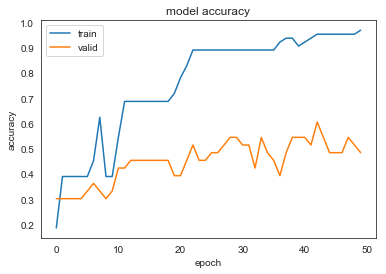

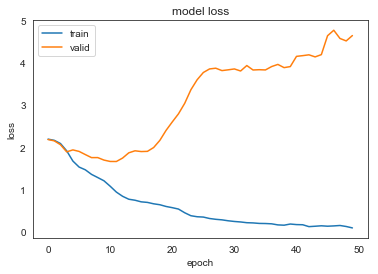

In [45]:
# Visualizando o historico de Acuracia
plt.plot(keras.history['acc'])
plt.plot(keras.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Visualizando o historico de perda
plt.plot(keras.history['loss'])
plt.plot(keras.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [46]:
# Fazer previsoes com dados de Teste
results = model.predict(X_test)

In [47]:
submission_df = pd.DataFrame(results, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = train_variants['ID']
submission_df.to_csv("data/submission.csv",index=False)
submission_df.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,1.935781e-02,0.978601,3.327489e-10,2.006682e-10,2.140730e-11,9.873558e-18,0.002041,6.712566e-17,8.965561e-10,0
1,6.709083e-06,0.140572,7.451594e-03,2.147838e-01,3.012470e-03,1.358268e-14,0.634173,2.042481e-14,2.005881e-07,1
2,1.069194e-06,0.033089,1.221923e-02,7.065270e-01,6.735349e-03,6.740523e-15,0.241429,6.475056e-15,7.287143e-08,2
3,1.772628e-06,0.000374,1.123369e-01,8.037865e-01,8.240484e-02,4.444381e-07,0.000994,5.791689e-08,1.014057e-04,3
4,1.584296e-08,0.000011,3.203896e-02,7.729523e-01,1.949843e-01,6.121124e-09,0.000004,7.624076e-11,9.639974e-06,4
